# numpy with JAX
This notebook compares and constrasts numpy and jax.numpy.  

In [4]:
# import numpy and JAX.numpy
import numpy as np
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt

## Arrays and built in functions
jax.numpy tries to be as numpy-like as possible. Below are examples of effectively unchanged syntax between these modules:

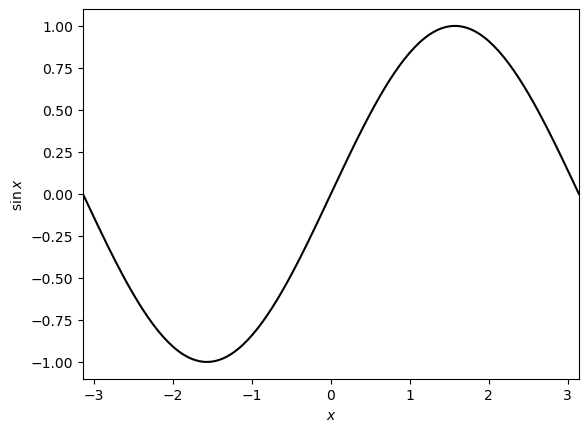

In [10]:
# numpy
n = 200
x = np.linspace(-np.pi, np.pi, n)
y = np.sin(x)

plt.plot(x, y, color='black')
plt.xlim(x[0], x[-1])
plt.ylabel(r'$\sin x$')
plt.xlabel(r'$x$')
plt.show()

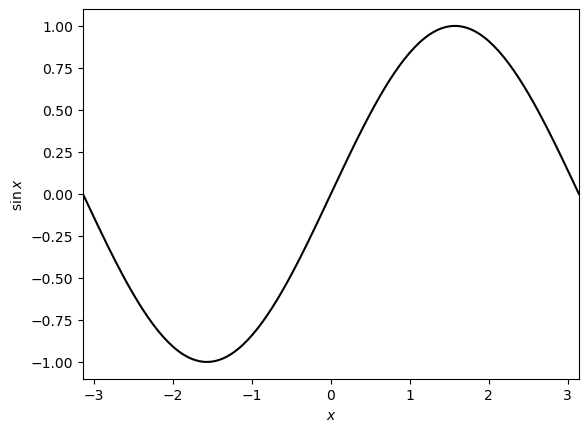

In [11]:
# jax.numpy
n = 200
x = jnp.linspace(-np.pi, np.pi, n)
y = jnp.sin(x)

plt.plot(x, y, color='black')
plt.xlim(x[0], x[-1])
plt.ylabel(r'$\sin x$')
plt.xlabel(r'$x$')
plt.show()

The two cells above are effectively identical on the surface. Behind the scenes, JAX is doing things differently, though.

In [14]:
# numpy
x = np.arange(0, 10, 1, dtype=int)
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [15]:
# jax.numpy
x = jnp.arange(0, 10, 1, dtype=int)
x

DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

### Does jax.numpy really speed things up?
Let's test with some straightforward matrix multiplication.  As you will hopefully see, there is a decent speed increase just by using jax.numpy for basic array manipulation.

In [33]:
# numpy
big_matrix1 = np.ones((5000, 4000))
big_matrix2 = np.ones((4000, 7000))

%timeit np.matmul(big_matrix1, big_matrix2)

2.81 s ± 89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
# jax.numpy
big_matrix1 = jnp.ones((5000, 4000))
big_matrix2 = jnp.ones((4000, 7000))

# Notice the block_until_ready() call.  This tells JAX to wait until computation is done before returning 
# something called a 'future'  (https://jax.readthedocs.io/en/latest/async_dispatch.html#async-dispatch).
%timeit jnp.matmul(big_matrix1, big_matrix2).block_until_ready()

1.59 s ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### jax.numpy is not numpy
Here is an example of where JAX differs notably from numpy --- namely, its implementation of random number generators.  Interestingly, here you see that numpy is beating JAX if you're running on CPUs.

In [35]:
# numpy
n = 1000
random_vector1 = np.random.randn(n)
random_vector2 = np.random.randn(n)

%timeit np.dot(random_vector1, random_vector2)

1.03 µs ± 4.24 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [36]:
# JAX
n = 1000
rand_key = jax.random.PRNGKey(123)
random_vector1 = jax.random.normal(rand_key, (n,))
random_vector2 = jax.random.normal(rand_key, (n,))

%timeit jnp.dot(random_vector1, random_vector2).block_until_ready()

4.66 µs ± 34.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Here is another example.  JAX is designed to be functional, which means no side effects.  More specifically, JAX works when inputs are not changed, so that a function f(x)=y does not change x.  Such a function can be considered 'mathematical', in the sense the input is not altered in memory: a new thing is returned and stored in memory.  The only results of calling such a function is producing an output.  Nothing else changes. 

Object oriented program allows for, and indeed thrives, on altering existing objects and their properties via methods or functions.  For example, with numpy you can alter a specific entry into a 2D array.  You could even automate this with an explicit function in your code.  JAX does not like this!

In [63]:
# numpy
def change_first_element(x, x0):
    x[0] = x0
    return None

x = np.asarray([0., 1., 2.])
print(x)
change_first_element(x, 4.)
print(x)

[0. 1. 2.]
[4. 1. 2.]


In [64]:
# JAX

x = jnp.asarray([0., 1., 2.])
print(x)
change_first_element(x, 4.)
print(x)

[0. 1. 2.]


TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

As was made obvious by the error message, you cannot directly change an element of a jax.numpy array.  They are immutable by construction.  There are ways around this using `x.at[index].set(new_value)`, as the error message states.

Below we change `change_first_element` to be JAX-compatible.  Notice that it indeed returns an array `y`, and this jax.numpy array is a new object in memory.  The original jax.numpy array `x` is left unchanged. 

In [69]:
def jax_change_first_element(x, x0):
    return x.at[0].set(x0)

x = jnp.asarray([0., 1., 2.])
print(x)
y = jax_change_first_element(x, 4.)
print(x)
print(y)
print()
print(id(x), id(y)) # notice that y is indeed a new object in memory!

[0. 1. 2.]
[0. 1. 2.]
[4. 1. 2.]

140667069438352 140667065649552


## Transforming Scalar-valued Functions with `grad`
A useful feature of JAX is its ability to transform numerical functions to their gradient via the `grad` function. Try to do this with numpy! As an example, let's take the gradient of the dot product of a vector with itself: $\nabla (\mathbf{x}\cdot\mathbf{x})=2x$.

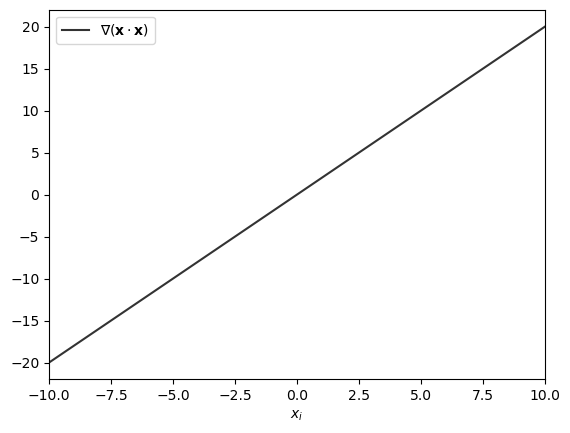

102 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [72]:
# JAX
def sum_squared(x):
    return jnp.sum(jnp.power(x, 2))

n = 100
x = jnp.linspace(-10., 10., n)
y = sum_squared(x)
y_grad = jax.grad(sum_squared)(x)

plt.plot(x, y_grad, color='black', alpha=0.8, label=r'$\nabla (\mathbf{x}\cdot\mathbf{x})$')
plt.xlim(x[0], x[-1])
plt.xlabel(r'$x_i$')
plt.legend()
plt.show()

%timeit [jax.grad(sin_squared)(i) for i in x]